In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
#from kneed import KneeLocator
#from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

import csv

# Read in the data, either 1, 2, or 3 for precipitation, soil, solar datasets respectively.
# Note, several processes run slow, which is why some of the tasks are commented out
dataset = 3

if dataset == 1:
  dataFile = '/content/drive/My Drive/Updated_Precipitation_Data_June_2000_Sep_2021_California.csv'
elif dataset == 2:
  dataFile = '/content/drive/My Drive/Updated_Soil_Mositure_2000_present_california.csv'
elif dataset == 3:
  dataFile = '/content/drive/My Drive/Solar_Radiation_Data.csv'

with open(dataFile) as f: 
    rows = list(csv.reader(f))  

print("Each row looks like:", rows[0])
print("We have", len(rows), "data points")

ignoreFirst = True
features = []
coords = []

import random
rows = random.sample(rows, 75000)

for row in rows:
    if not ignoreFirst:
        
        # for precipitation, our features are [latitude, longitude, precipitation]
        if dataset == 1:
          features.append([float(row[2]),float(row[3]), float(row[4])])
          coords.append([float(row[2]), float(row[3]), -1])
         
        # for soil moisture, our features are [latitude, longitude, soil moisture in  kg m-2, soil moisture availability percentage, average surface temperature in K]
        elif dataset == 2:
          features.append([float(row[2]),float(row[3]), float(row[4]), float(row[5]), float(row[6])])
          coords.append([float(row[2]), float(row[3]), -1])

        # for solar radiation, our features are [latitude, longitude, LWGAB]
        elif dataset == 3:
          features.append([float(row[1]),float(row[2]), float(row[3])])
          coords.append([float(row[1]), float(row[2]), -1])

    ignoreFirst = False

# have to scale our features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

precipitation = []
moisture = []
percent = []
temp = []
lwgab = []

for elem in scaled_features:
  if dataset == 1:
    precipitation.append(elem[2])
  elif dataset == 2:
    moisture.append(elem[2])
    percent.append(elem[3])
    temp.append(elem[4])
  if dataset == 3:
    lwgab.append(elem[2])
  

print("first element of scaled features is", scaled_features[0])

if dataset == 1:
  num_centers = 2
elif dataset == 2 or dataset == 3:
  num_centers = 3

# determine best sse (only do this once, since its slow)
plottingSSE = False
if plottingSSE:
  sseList = []
  for i in range(1, 6):
      kmeans = KMeans(
          init="random",
          n_clusters=i,
          n_init=10,
          max_iter=50,
          random_state=42
      )
      kmeans.fit(scaled_features)
      sseList.append(kmeans.inertia_)

  # plot our sse
  plt.plot(range(1, 6), sseList)
  plt.xticks(range(1, 6))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  plt.show()


Each row looks like: ['', 'Date Time in YYYY-MM-DD', 'Latitude', 'Longitude', 'Soil Moisture in  kg m-2', 'Soil moisture availability Percentage', 'Average surface temperature in K']
We have 1772801 data points
first element of scaled features is [0.75360233 0.06704807 0.58013573 0.57686777 0.57391444]


In [3]:
# determine quartiles, and plot the distribution

precipitation = []

moisture = []
percent = []
temp = []

lwgab = []


plotting = False

if plotting == True:
  if dataset == 1:
    print("Precipitation:")
    print("Min:", np.percentile(precipitation,0))
    print("1st quartile:", np.percentile(precipitation, 25))
    print("middle quartile:", np.percentile(precipitation, 50))
    print("3rd quartile:", np.percentile(precipitation, 75))
    print("Max:", np.percentile(precipitation,100))
    plt.boxplot(precipitation)

  elif dataset == 2:
    print("Moisture:")
    print("Min:", np.percentile(moisture,0))
    print("1st quartile:", np.percentile(moisture, 25))
    print("middle quartile:", np.percentile(moisture, 50))
    print("3rd quartile:", np.percentile(moisture, 75))
    print("Max:", np.percentile(moisture,100))
    plt.boxplot(moisture)
    plt.show()

    print("Percent:")
    print("Min:", np.percentile(percent,0))
    print("1st quartile:", np.percentile(percent, 25))
    print("middle quartile:", np.percentile(percent, 50))
    print("3rd quartile:", np.percentile(percent, 75))
    print("Max:", np.percentile(percent,100))
    plt.boxplot(percent)
    plt.show()

    print("Temperature:")
    print("Min:", np.percentile(temp,0))
    print("1st quartile:", np.percentile(temp, 25))
    print("middle quartile:", np.percentile(temp, 50))
    print("3rd quartile:", np.percentile(temp, 75))
    print("Max:", np.percentile(temp,100))
    plt.boxplot(temp)
    plt.show()

  elif dataset == 3:
    print("lwgab:")
    print("Min:", np.percentile(lwgab,0))
    print("1st quartile:", np.percentile(lwgab, 25))
    print("middle quartile:", np.percentile(lwgab, 50))
    print("3rd quartile:", np.percentile(lwgab, 75))
    print("Max:", np.percentile(lwgab,100))
    plt.boxplot(lwgab)

row length is 75000
feature length is 74999


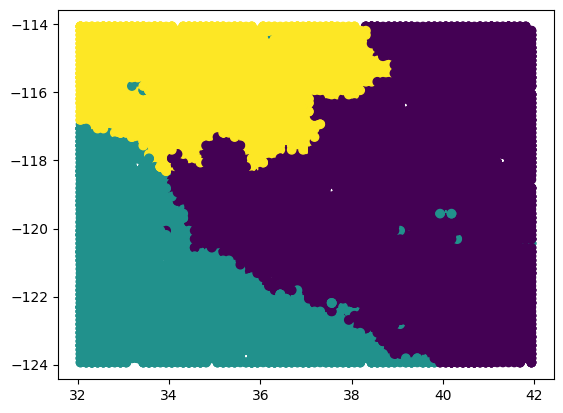

[0.2345056359117703, -1.3140628429846413, -1.7344208352947244, -1.734745244845609, -1.7347457475677175]
1
averages for cluster 1 are 0.5806012123111164 0.5769128229909156 0.5760024843091955
averages for cluster 2 are -1.7344208352947244 -1.734745244845609 -1.7347457475677175
averages for cluster 3 are 0.5687088525781488 0.5756553708851226 0.5774261218494323


In [4]:
# set up a heirarchal clustering model
from scipy.cluster.hierarchy import dendrogram, linkage
import random as r

list_scaled_features = scaled_features.tolist()

sample_features = []
sample_coords = []

print("row length is", len(rows))
print("feature length is", len(list_scaled_features))

for i in range(25000 - 1):
  index = r.randint(0, len(rows) - 2)
  sample_features.append(list_scaled_features[index])
  sample_coords.append(coords[index])

'''
linkage_data = linkage(sample_features, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()
'''

from sklearn.cluster import AgglomerativeClustering

#Here we use a simple euclidean distance measure and Ward's linkage, which seeks to minimize the variance between clusters.
hierarchical_cluster = AgglomerativeClustering(n_clusters=num_centers, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(sample_features)
# here labels are a separate list

# split up our coordinates
x = []
y = []
heirarchal_labeled_coords = []
np_heirarchal_coords = []

for i in range(len(sample_coords)):
  point = sample_coords[i]
  x.append(point[0])
  y.append(point[1])
  sample_coords[i][2] = labels[i]

  heirarchal_labeled_coords.append(sample_coords[i])
  heirarchal_labeled_coords[i].append(labels[i])
  np_heirarchal_coords.append([point[0], point[1]])

plt.scatter(x, y, c=labels)
plt.show()

np_heirarchal_coords = np.array(np_heirarchal_coords)

print(sample_features[0])
print(labels[0])

precipitation1 = []
precipitation2 = []
moisture1 = []
moisture2 = []
moisture3 = []
percent1 = []
percent2 = []
percent3 = []
temp1 = []
temp2 = []
temp3 = []
lwgab1 = []
lwgab2 = []
lwgab3 = []
# determine cluster averages
for i in range(len(sample_features)):
  features = sample_features[i]

  if dataset == 1:
    if labels[i] == 0:
      precipitation1.append(features[2])
    elif labels[i] == 1:
      precipitation2.append(features[2])
  
  elif dataset == 2:
    if labels[i] == 0:
      moisture1.append(features[2])
      percent1.append(features[3])
      temp1.append(features[4])
    elif labels[i] == 1:
      moisture2.append(features[2])
      percent2.append(features[3])
      temp2.append(features[4])
    elif labels[i] == 2:
      moisture3.append(features[2])
      percent3.append(features[3])
      temp3.append(features[4])

  elif dataset == 3:
    if labels[i] == 0:
      lwgab1.append(features[2])
    elif labels[i] == 1:
      lwgab2.append(features[2])
    elif labels[i] == 2:
      lwgab3.append(features[2])

if dataset == 1:
  print("average precip for cluster 1 is", np.percentile(precipitation1, 50))
  print("average precip for cluster 2 is", np.percentile(precipitation2, 50))

if dataset == 2:
  print("averages for cluster 1 are", np.percentile(moisture1, 50), np.percentile(percent1, 50), np.percentile(temp1, 50))
  print("averages for cluster 2 are", np.percentile(moisture2, 50), np.percentile(percent2, 50), np.percentile(temp2, 50))
  print("averages for cluster 3 are", np.percentile(moisture3, 50), np.percentile(percent3, 50), np.percentile(temp3, 50))

if dataset == 3:
  print("average lwgab for cluster 1 is", np.percentile(lwgab1, 50))
  print("average lwgab for cluster 2 is", np.percentile(lwgab2, 50))
  print("average lwgab for cluster 2 is", np.percentile(lwgab3, 50))


IndexError: ignored

In [ ]:
import matplotlib.pyplot as plt

# plot the coordinates by cluster
class1Lat = []
class1Lon = []

class2Lat = []
class2Lon = []

class3Lat = []
class3Lon = []

class4Lat = []
class4Lon = []

for elem in sample_coords:
#for elem in coords:
  if elem[2] == 0:
    class1Lat.append(abs(elem[0]))
    class1Lon.append(abs(elem[1]) - 20)
  if elem[2] == 1:
    class2Lat.append(abs(elem[0]))
    class2Lon.append(abs(elem[1]) - 20)
  if elem[2] == 2:
    class3Lat.append(abs(elem[0]))
    class3Lon.append(abs(elem[1]) - 20)
  if elem[2] == 3:
    class4Lat.append(abs(elem[0]))
    class4Lon.append(abs(elem[1]) - 20)

fig = plt.figure()
ax = fig.add_subplot()

plt.scatter(class1Lon, class1Lat, zorder=1, alpha= 1, c='b', s=5)
plt.scatter(class2Lon, class2Lat, zorder=1, alpha= 1, c='r', s=5)
plt.scatter(class3Lon, class3Lat, zorder=1, alpha= 1, c='g', s=5)
plt.scatter(class4Lon, class4Lat, zorder=1, alpha= 1, c='y', s=5)

ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# set up our kmeans model
kmeans = KMeans(
        init="random",
        n_clusters=num_centers,
        n_init=10,
        max_iter=100,
        random_state=42
    )

kmeans.fit(scaled_features)
print("Length of labels", len(kmeans.labels_))

# final centers
print("Final centers:", kmeans.cluster_centers_)

X = scaled_features
y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 2')
if dataset == 2 or dataset == 3:
  plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=100, c='green', label ='Cluster 3')

#Plot the centroids. 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')

plt.show()
  
# label our coordinates with the y value
for i in range(len(y_kmeans)):
  coords[i][2] = y_kmeans[i]

np_kmeans_coords = []
for i in range(len(coords)):
  np_kmeans_coords.append([0,0])
  np_kmeans_coords[i][0] = coords[i][0]
  np_kmeans_coords[0][1] = coords[i][1]
np_kmeans_coords = np.array(np_kmeans_coords)

In [ ]:
from sklearn.metrics.pairwise import distance
with open('/content/drive/My Drive/California_Power_Plants.csv') as f:  
    rows = list(csv.reader(f))  

# determine how many power plants are in each cluster
ignoreFirst = True
plants = []

for row in rows:
    if not ignoreFirst:
        plants.append([float(row[1]),float(row[0])])
    ignoreFirst = False

import math
print("We have to check", len(plants), "power plants")

plant_clusters = [0,0,0,0,0,0,0,0,0,0,0]

for i in range(len(plants)):
  print(i)
  closest = 0
  closest_dist = 999999999
  for j in range(len(sample_coords)):
    dist = math.dist(sample_coords[j][:2], plants[i])
    if dist < closest_dist:
      closest = j
      closest_dist = dist

  cluster_label = sample_coords[closest][2]
  plant_clusters[cluster_label] += 1

for i in range(len(plant_clusters)):
  cluster_value = plant_clusters[i]
  if cluster_value!= 0:
    print("There are", cluster_value, "plants in cluster number", i)

In [ ]:
# Evaluate the clustering methods

# Silhouette Coefficient measures the between-cluster distance against within-cluster distance. A higher score signifies better-defined clusters

# commented out the kmeans because its slow

#kmeans_score = silhouette_score(np_kmeans_coords, y_kmeans, metric='euclidean')
#print("Silhouette coefficient for kmeans using euclidean distance is", kmeans_score)

heirarchal_score = silhouette_score(np_heirarchal_coords, labels, metric='euclidean')
print("Silhouette coefficient for heirarchal clustering using euclidean distance is", heirarchal_score)

#kmeans_score = silhouette_score(np_kmeans_coords, y_kmeans, metric='cityblock')
#print("Silhouette coefficient for kmeans using Manhattan distance is", kmeans_score)

heirarchal_score = silhouette_score(np_heirarchal_coords, labels, metric='cityblock')
print("Silhouette coefficient for heirarchal clustering using Manhattan distance is", heirarchal_score)

#kmeans_score = silhouette_score(np_kmeans_coords, y_kmeans, metric='cosine')
#print("Silhouette coefficient for kmeans using cosine distance is", kmeans_score)

heirarchal_score = silhouette_score(np_heirarchal_coords, labels, metric='cosine')
print("Silhouette coefficient for heirarchal clustering using cosine distance is", heirarchal_score)
